In [132]:
from mpl_toolkits import mplot3d

%matplotlib inline
import numpy as np
import math as math
import matplotlib.pyplot as plt

In [133]:
"""
Plot styling
"""
%matplotlib inline
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = [8, 6]

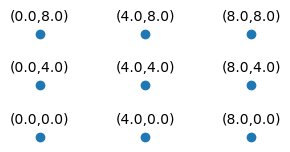

In [139]:
"""
Locations plot
"""
locations = np.array(np.meshgrid(np.linspace(0, 8, 3), np.linspace(0, 8, 3))).T.reshape(-1, 2)

plt.figure(figsize=(3,1.5))
plt.scatter(locations[:,0], locations[:,1])

plt.axis('off')

for x,y in zip(locations[:,0],locations[:,1]):

    label = f"({x},{y})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

In [143]:
"""
Compute Euclidean distance vector
    
    target --> Reference AP location to calculate distance
    array --> Array of AP/VRP locations
"""
def compute_euclidean_distance_vector(target, array):
    d_vec = np.array([np.linalg.norm(target - i) for (i) in array])
    return d_vec

In [144]:
# ----------------------------------------------------------------------
#  AP RTT distance observations
ap_loc = locations[0]

d_RTT = compute_euclidean_distance_vector(ap_loc, locations)

In [140]:
def surface_fit(x, y):
    return np.sin(np.sqrt(x ** 2 + y ** 2))

In [145]:
x = np.linspace(0, 8, 50)
y = np.linspace(0, 8, 50)

X, Y = np.meshgrid(x, y)
Z = surface_fit(X, Y)

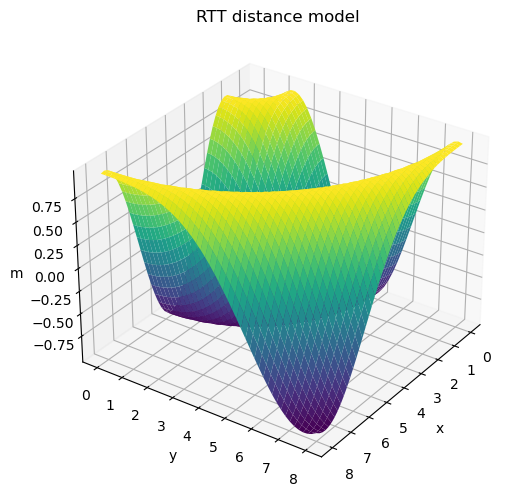

In [146]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('m')

ax.view_init(30, 35)

ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('RTT distance model');